# Neural Collaborative Filtering

## NCF Architecture 

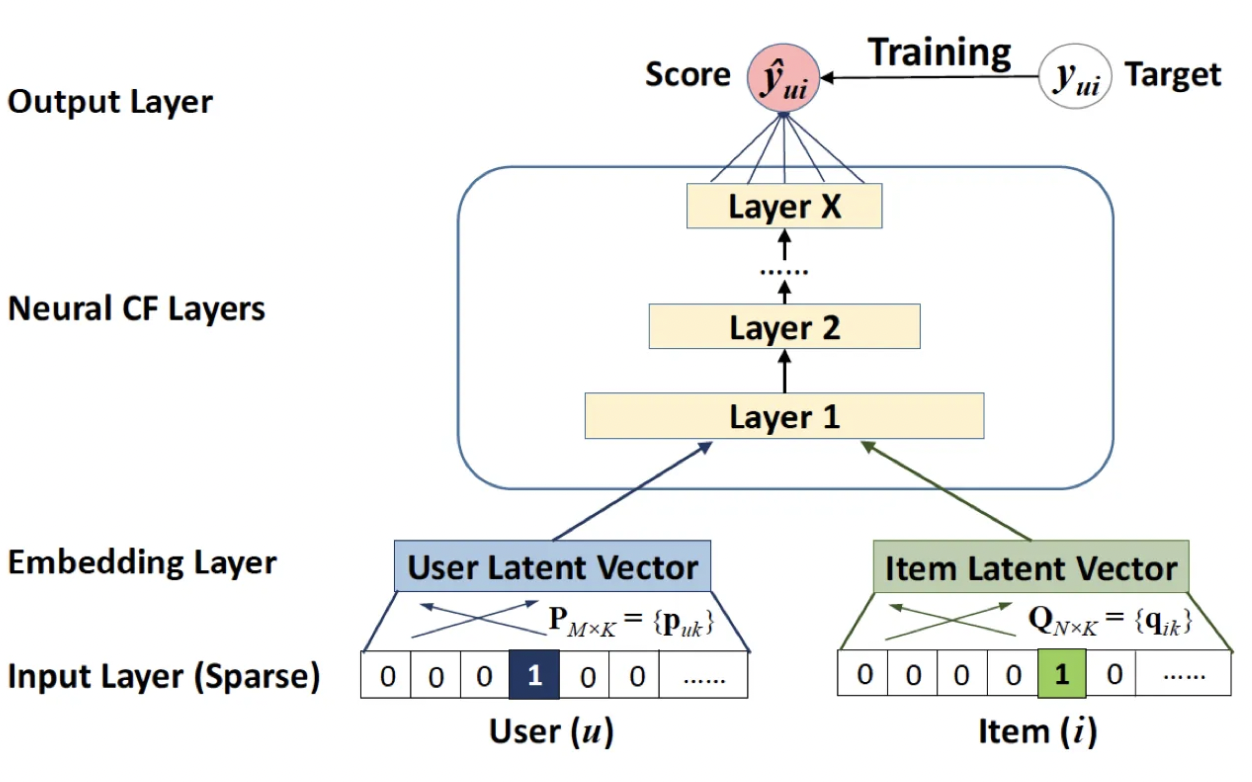
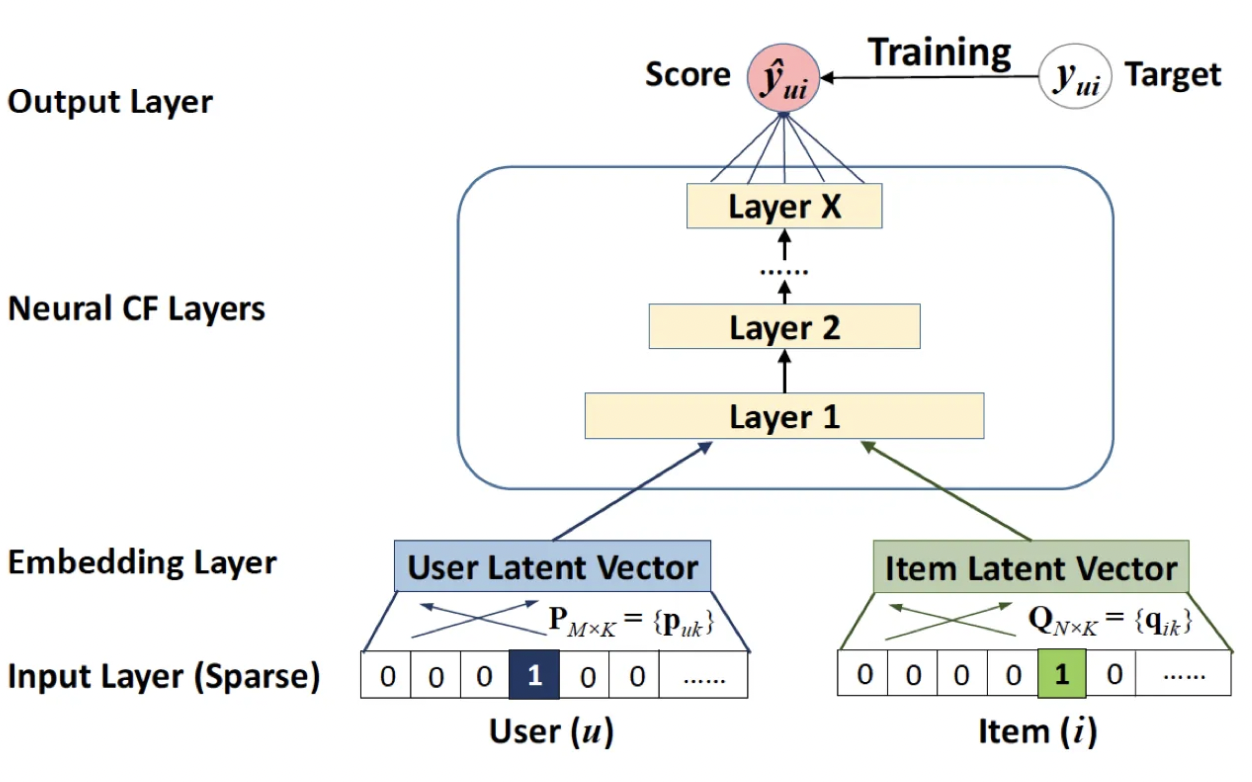
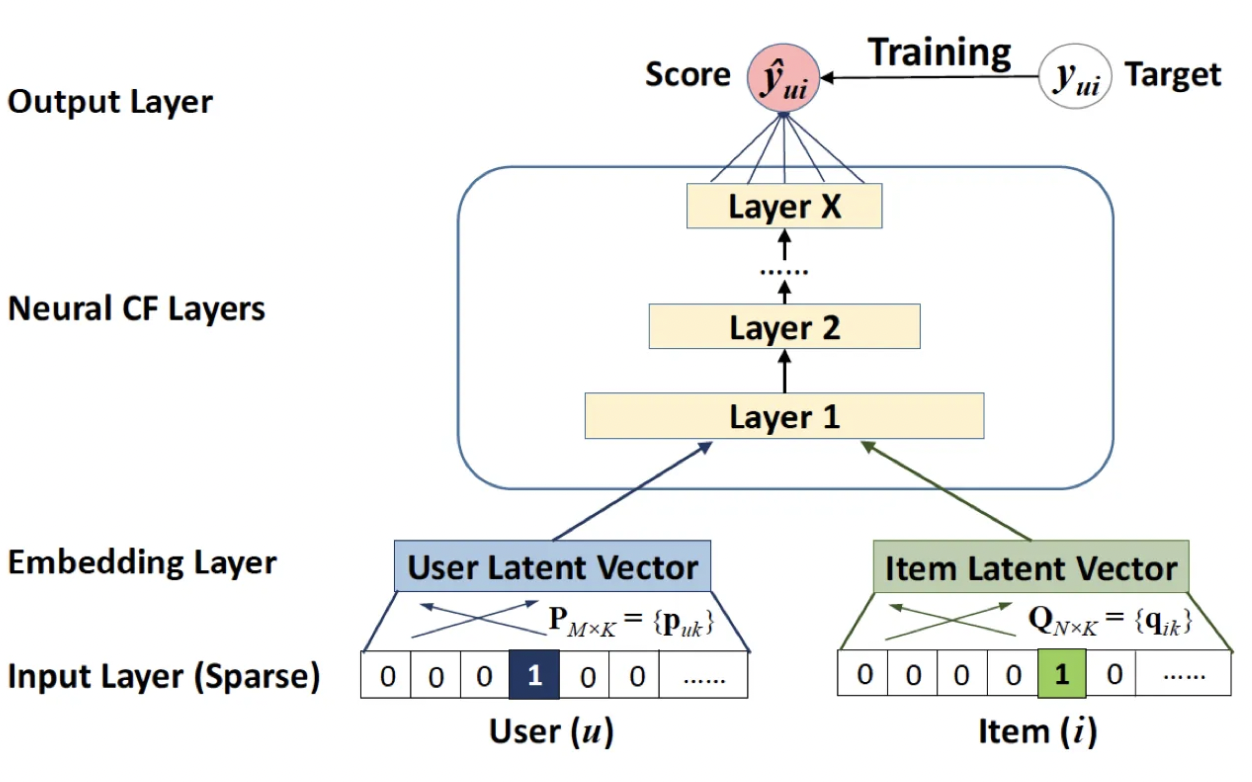
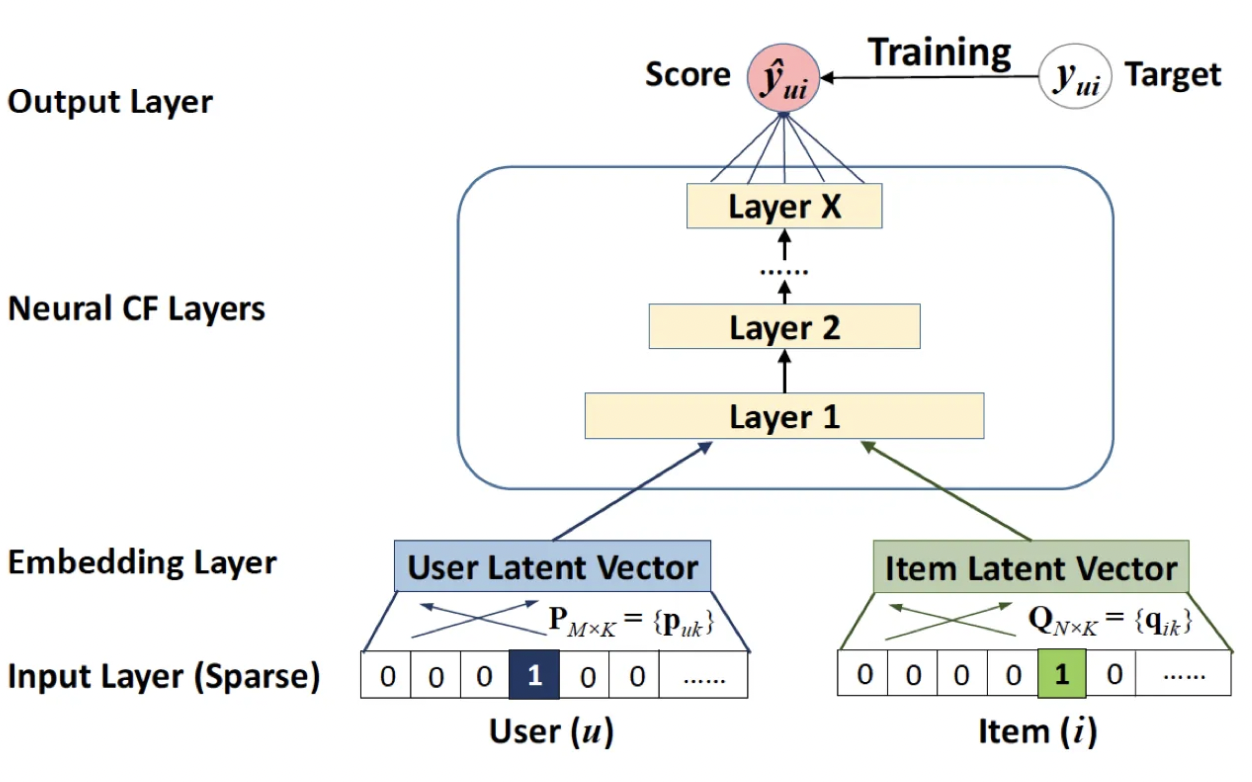

## Data Loading And Preprocessing

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("/kaggle/input/movielens-32m/ml-32m/ratings.csv")
data.drop(columns=["timestamp"], inplace=True)
data.head()


,userId,movieId,rating
0,1,17,4.0
1,1,25,1.0
2,1,29,2.0
3,1,30,5.0
4,1,32,5.0


In [2]:
user_mapping = {user_id: idx for idx, user_id in enumerate(data['userId'].unique())}
item_mapping = {item_id: idx for idx, item_id in enumerate(data['movieId'].unique())}

data['userId'] = data["userId"].map(user_mapping)
data['movieId'] = data['movieId'].map(item_mapping)

num_users = len(user_mapping)
num_items = len(item_mapping)

print(f"Numbers of users: {num_users}\nNumber of movies: {num_items}")

Numbers of users: 200948
Number of movies: 84432


In [3]:
from sklearn.model_selection import train_test_split

x = data[['userId', 'movieId']].values
y = (data['rating'] > 3).astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 25600163, Testing samples: 6400041


In [4]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

batch_size = 256

train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [5]:
def preprocess(data):
    user_ids = data[:, 0]
    item_ids = data[:, 1]
    return {"user_id": user_ids, "item_id": item_ids}

train_dataset = train_dataset.map(lambda x, y: (preprocess(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocess(x), y))

In [6]:
for batch in train_dataset.take(1):
    inputs, labels = batch
    print("User IDs:", inputs['user_id'][:5].numpy())
    print("Item IDs:", inputs['item_id'][:5].numpy())
    print("Labels:", labels[:5].numpy())

User IDs: [ 74358  52531  40164 197739  14798]
Item IDs: [ 123  514  785 1295  247]
Labels: [1. 1. 1. 1. 1.]


## Model Creation 

In [7]:
from tensorflow.keras import layers, Model
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable(package="NCFModel")
class NCFModel(Model):
    def __init__(self, num_users, num_items, embedding_dim=16, mlp_layers=[64, 32, 16], **kwargs):
        super(NCFModel, self).__init__(**kwargs)

        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.mlp_layers_config = mlp_layers

        self.user_embedding_gmf = layers.Embedding(input_dim = num_users, output_dim = embedding_dim)
        self.item_embedding_gmf = layers.Embedding(input_dim = num_items, output_dim = embedding_dim)

        self.user_embedding_mlp = layers.Embedding(input_dim = num_users, output_dim = embedding_dim)
        self.item_embedding_mlp = layers.Embedding(input_dim = num_items, output_dim = embedding_dim)

        self.mlp_layers = tf.keras.Sequential()
        for units in mlp_layers:
            self.mlp_layers.add(layers.Dense(units, activation='relu'))

        self.concat_layer = layers.Concatenate()
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        user_ids, item_ids = inputs["user_id"], inputs['item_id']
        gmf_user = self.user_embedding_gmf(user_ids)
        gmf_item = self.item_embedding_gmf(item_ids)
        gmf_output = gmf_user * gmf_item

        mlp_user = self.user_embedding_mlp(user_ids)
        mlp_item = self.item_embedding_mlp(item_ids)
        mlp_input = tf.concat([mlp_user, mlp_item], axis=-1)
        mlp_output = self.mlp_layers(mlp_input)

        combined = self.concat_layer([gmf_output, mlp_output])

        return self.output_layer(combined)
    def get_config(self):
        # Returns the configuration to save the model
        config = super().get_config()
        config.update({
            "num_users": self.num_users,
            "num_items": self.num_items,
            "embedding_dim": self.embedding_dim,
            "mlp_layers": self.mlp_layers_config,
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Creates the model from the saved configuration
        return cls(
            num_users=config["num_users"],
            num_items=config["num_items"],
            embedding_dim=config["embedding_dim"],
            mlp_layers=config["mlp_layers"],
        )

In [8]:

ncf_model = NCFModel(num_users=200948, num_items=84432, embedding_dim=16, mlp_layers=[64, 32, 16])


In [9]:
ncf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'mse', 'mae']
)


In [10]:
ncf_model.summary()

Model: "ncf_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate (Concatenate)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Training The Model

In [11]:
ncf_model.fit(
    train_dataset,  
    validation_data=test_dataset,
    epochs=1,
    batch_size=256
)


I0000 00:00:1732784999.443291     310 service.cc:145] XLA service 0x78f0b4058920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732784999.443349     310 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732784999.443353     310 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


    34/100001 ━━━━━━━━━━━━━━━━━━━━ 7:52 5ms/step - accuracy: 0.5875 - loss: 0.6864 - mae: 0.4960 - mse: 0.2466  

I0000 00:00:1732785000.813665     310 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100001/100001 ━━━━━━━━━━━━━━━━━━━━ 502s 4ms/step - accuracy: 0.7432 - loss: 0.5176 - mae: 0.3451 - mse: 0.1726 - val_accuracy: 0.7740 - val_loss: 0.4699 - val_mae: 0.3090 - val_mse: 0.1542


## Evaluation

In [13]:
loss, accuracy, _, _ = ncf_model.evaluate(test_dataset)
print(f"Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")

25001/25001 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.7741 - loss: 0.4699 - mae: 0.3090 - mse: 0.1542
Loss = 0.4699, Accuracy = 0.7740


In [14]:
ncf_model.summary()

Model: "ncf_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,215,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ ?                      │     1,350,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ ?                      │     3,215,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ ?                      │     1,350,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │         4,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate (Concatenate)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,410,741 (104.56 MB)

 Trainable params: 9,136,913 (34.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,273,828 (69.71 MB)

In [15]:
ncf_model.save("/kaggle/working/ncf_model.keras")


![predictions.png](predictions.png)